# Step 1: Exchange pairs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import time
np.set_printoptions(suppress = True)

In [5]:
df_matched = pd.read_stata('sample_matched_demean.dta')
df_unmatched = pd.read_stata('sample_unmatched_demean.dta').iloc[:,: 7]

In [6]:
df_matched

,lender_id,loan_id,var1,var2,var3,var4,var5,USPS_ZIP_PREF_CITY,USPS_ZIP_PREF_STATE,yearapproved
0,5051.0,97252.0,-0.001122,-550.811646,3.875915e+05,0.091452,0.045413,AGAWAM,MA,2020.0
1,4081.0,78177.0,-0.001122,-334.724243,-8.013543e+05,0.091452,-0.070219,AGAWAM,MA,2020.0
2,2605.0,27917.0,-0.001122,-560.586060,-1.799459e+05,0.184932,-0.347326,AGAWAM,MA,2020.0
3,1339.0,31464.0,-0.001122,-544.871094,1.192297e+05,-0.078142,-0.070219,AMHERST,MA,2020.0
4,2129.0,40976.0,-0.001122,-547.824036,2.413198e+05,0.014364,-0.070219,AMHERST,MA,2020.0
...,...,...,...,...,...,...,...,...,...,...
88834,1631.0,34115.0,-0.001122,-560.586060,1.404330e+05,-0.024180,0.045413,KETCHIKAN,AK,2020.0
88835,1631.0,34117.0,-0.001122,-560.586060,-1.448854e+06,-0.024180,0.045413,KETCHIKAN,AK,2020.0
88836,1631.0,34122.0,-0.001122,-494.896057,1.634662e+05,-0.139812,0.045413,CRAIG,AK,2020.0
88837,1631.0,34127.0,-0.001122,-498.872070,3.707646e+05,-0.139812,0.045413,WRANGELL,AK,2020.0


In [416]:
df_matched = pd.read_stata('sample_matched_NY_demean1.dta').iloc[:,: 7]
df_unmatched = pd.read_stata('sample_unmatched_NY_demean1.dta').iloc[:,: 7]

In [7]:
df_matched = pd.read_stata('sample_matched_NY_demean1.dta').iloc[:,: 7]
df_unmatched = pd.read_stata('sample_unmatched_NY_demean1.dta').iloc[:,: 7]

'''
df_matched = pd.read_stata('test_sample_matched.dta')
df_unmatched = pd.read_stata('sample_unmatched.dta')
'''
def Exchange_pairs(df_matched, df_unmatched):
    # t1 = time.time()
    
    df_matched_column = df_matched.columns
    df_matched.columns = df_matched_column + '1m'
    df_unmatched.columns = df_unmatched.columns.str.replace('lender_id', 'lender_id1m')
    df1 = pd.merge(df_matched, df_unmatched, on = 'lender_id1m', how = 'inner')
    
    l = df1.columns[:-6].append([df1.columns[-6:] + '1um'])
    df1.columns = l
    df_matched.columns = df_matched_column
    df2 = pd.merge(df_matched, df1, left_on = 'loan_id', right_on = 'loan_id1um', how = 'inner') 
    
    ll = (df2.columns[:7]+'2m').append(df2.columns[7:])
    df2.columns = ll
    df_unmatched.columns = df_unmatched.columns.str.replace('lender_id1m', 'lender_id')
    df3 = pd.merge(df_unmatched, df2, left_on = ['lender_id','loan_id'], right_on = ['lender_id2m','loan_id1m'], how = 'inner')
    lll = (df3.columns[:7]+'2um').append(df3.columns[7:])
    df3.columns = lll
    
    df_keep = pd.DataFrame()
    for i in range(1, 6):
        name = "value" + str(i)
        df_keep[name] = df3["var"+str(i)+"1m"] + df3["var"+str(i)+"2m"] - df3["var"+str(i)+"1um"] - df3["var"+str(i)+"2um"]
    # t2 = time.time()
    # print("Running time: ", t2-t1)
    return df_keep
df_keep = Exchange_pairs(df_matched, df_unmatched)
df_keep

,value1,value2,value3,value4,value5
0,1.0,-196.802643,-6.432140e+06,1.862645e-09,0.0
1,1.0,-199.432587,-6.432144e+05,0.000000e+00,0.0
2,1.0,-195.945038,1.286428e+06,-5.587935e-09,0.0
3,0.0,-190.481293,-3.216070e+06,1.862645e-09,0.0
4,0.0,-188.347870,-4.180891e+06,1.862645e-09,0.0
...,...,...,...,...,...
11463945,0.0,-163.896790,-2.731600e+04,2.000000e+00,-1.0
11463946,0.0,-163.896790,1.092640e+05,2.600000e+00,-1.0
11463947,0.0,-152.651550,-5.463202e+04,3.000000e+00,0.0
11463948,0.0,-31.092957,-1.092640e+05,4.000000e+00,-1.0


# Step 2: Define objective function 

Step 2: Define objective function -- (P15 equation 7 in Fox (2018) or P818 equation 4 in Schwert (2018) )
define a function that calculates the score of the matching model for given parameters
i.e. count how many inequalities are satisfied under given parameters 
objective function (score) =sum of 1(inequalities satisfied), where
$$Inequalities = beta \times value \geqslant 0$$
$\beta$ is the parameter vector
Value vector for a given data point (i.e. value 1-6 for a given data point)
Hint: apply (multiply) the parameter vector to the data matrix (transposed) and then count the non-negative values

The objective function $$Q(\beta) = \Sigma \mathbb{1}[X_{N\times 6}\beta_{6\times 1}]$$

# Step 3: Differential Evolution

In [64]:
# use differential_evolution in scipy.optimize to find the parameters than maximize the score calculated in step 2
# Reference
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
# https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/

In [18]:
df_test = df_keep.iloc[: 5, :]
df_test

,value1,value2,value3,value4,value5
0,1.0,-128.862122,95195504.0,0.000000,0.0
1,1.0,-123.937958,96773328.0,0.000000,0.0
2,0.0,94.940582,97036304.0,0.000000,0.0
3,0.0,-97.312332,23914.0,3.413793,0.0
4,0.0,-97.312332,0.0,0.413793,1.0


In [161]:
# 1. When input, make sure df contains all the values you need
# 2. specify df = X in def objectfunc(beta, df = df_test) before you run differential_evolution
def objectfunc(beta, df = df_keep):
    '''
    num = df.shape[1] # This is the num of Parameters( dimension of beta)
    obj = 0
    for i in range(0, num):
        obj = obj + np.array(df.iloc[:, i]) * beta[i]
        # print(obj)
    return -sum(obj >= 0)
    '''
    return -sum(df.dot(beta) >=0 )

In [162]:
# This is a test for debugging
beta = np.array([1, 2, 3, 4, 5])
obj = objectfunc(beta, df_keep)
obj

-5908089

In [163]:
# This is a test for debugging
beta = np.array([1, 2, 3, 4, 5])
obj = objectfunc(beta, df_test)
obj

-4

In [164]:
# specify bounds of every parameters
'''
num = df_test.shape[0]
num = df_test.shape[0]
bounds = [(-100, 100)] * num
'''
t1 = time.time()
bounds = [(1, 1.000000001), (-100, 100), (-100, 100), (-100, 100), (-100, 100)]
result = differential_evolution(objectfunc, bounds)
print(result)
t2 = time.time()
print("Running time: ", t2-t1)

     fun: -5989014.0
 message: 'Optimization terminated successfully.'
    nfev: 306
     nit: 3
 success: True
       x: array([  1.        ,  -4.47262905,  36.31679535, -41.54346339,
        88.40841153])
Running time:  364.816956281662


In [355]:
print("The bumber of inequalities satisfied is")
print(round(-result.fun))

The bumber of inequalities satisfied is
5989014


# Step 4: Use subsampling to construct confidence intervals

The idea is to select some random subsamples (100-200) that mimics the original sample and re-do the step1-3 and get another estimated parameter. Then calculate the 5% and 95% percentile of the 100 (200) parameters.
To mimic the original sample, we choose the subsample for fixed share for each state.

In [180]:
'''
# The random sampling ratio = 10% here
def Subsample(df, ratio):
    # t1 = time.time()
    df_sample = df.loc[np.random.choice(df.index, round(len(df) * ratio), replace = False)]
    # t2 = time.time()
    # print("Running time: ", t2-t1)
    return df_sample
df_matched_sample = Subsample(df_matched, 0.1)
df_unmatched_sample = Subsample(df_unmatched, 0.1)
'''

'\n# The random sampling ratio = 10% here\ndef Subsample(df, ratio):\n    # t1 = time.time()\n    df_sample = df.loc[np.random.choice(df.index, round(len(df) * ratio), replace = False)]\n    # t2 = time.time()\n    # print("Running time: ", t2-t1)\n    return df_sample\ndf_matched_sample = Subsample(df_matched, 0.1)\ndf_unmatched_sample = Subsample(df_unmatched, 0.1)\n'

In [349]:
df_matched

,lender_id,loan_id,var1,var2,var3,var4,var5
0,814.0,19445.0,0.0,11.481559,2150.0,0.0,0.0
1,275.0,3498.0,1.0,169.902786,11088.0,0.0,0.0
2,3096.0,60530.0,1.0,7.044008,2823.0,0.0,0.0
3,3813.0,71810.0,0.0,1.056799,28242.0,0.0,0.0
4,60.0,456.0,0.0,3.011763,1764.0,0.0,0.0
...,...,...,...,...,...,...,...
6000,1085.0,23929.0,0.0,222.663376,38430.0,0.0,0.0
6001,1085.0,23938.0,0.0,222.663376,96075.0,0.0,0.0
6002,1795.0,36141.0,0.0,20.144510,5346.0,0.0,0.0
6003,1795.0,36138.0,0.0,17.873976,5346.0,0.0,0.0


In [353]:
# num is the # of random samples(or the # of simulations)
# ratio is the random sampling ratio, which is 10% here
def Simulation(num, ratio, df_matched, df_unmatched):
    df_result = pd.DataFrame()
    for i in range(0, num):
        # df_matched_sample = Subsample(df_matched, ratio)
        # df_unmatched_sample = Subsample(df_unmatched, ratio)
        
        loan_id = df_matched["loan_id"].unique() # loan_id = df_unmatched["loan_id"].unique() -- 应该是从matched里取~
        sample_loan_id = np.random.choice(loan_id, round(loan_id.shape[0] * ratio), replace = False)
        df_unmatched_sample = df_unmatched.loc[df_unmatched["loan_id"].isin(sample_loan_id)]
        df_matched_sample = df_matched.loc[df_matched["loan_id"].isin(sample_loan_id)]
       
        df_keep = Exchange_pairs(df_matched_sample, df_unmatched_sample)
        bounds = [(1, 1.000000001), (-100, 100), (-100, 100), (-100, 100), (-100, 100)] # fix beta_1 = 1
        result = differential_evolution(objectfunc, bounds)
        df_result = df_result.append(pd.Series(result.x), ignore_index = True)
        # print(i)
    print("The 5% quantile of parameters are")
    print(df_result.quantile(0.05))
    print("The 95% quantile of parameters are")
    print(df_result.quantile(0.95))
    return df_result


t1 = time.time()
df_result = Simulation(10, 0.1, df_matched, df_unmatched)
t2 = time.time()
print("Simulation time: ", t2-t1)
df_result

The 5% quantile of parameters are
0     1.000000
1   -99.151884
2     0.010407
3   -95.174940
4   -82.695684
Name: 0.05, dtype: float64
The 95% quantile of parameters are
0     1.000000
1   -36.245882
2     0.493030
3    98.743652
4    89.493345
Name: 0.95, dtype: float64
Simulation time:  8354.007978200912


,0,1,2,3,4
0,1.0,-99.231250,0.004879,-12.488045,-54.667913
1,1.0,-78.910727,0.507259,39.188229,25.413048
2,1.0,-64.231139,0.086076,-95.673616,-64.225877
3,1.0,-70.381379,0.264324,-30.725268,-75.176655
4,1.0,-87.567491,0.026632,-7.489319,84.613679
5,1.0,-71.167678,0.025789,99.757212,76.561598
6,1.0,-86.993004,0.310994,97.504857,-88.847617
7,1.0,-86.512356,0.023114,-62.291873,52.593936
8,1.0,-13.348854,0.475639,-86.376915,23.807160
9,1.0,-99.054880,0.017162,-94.565448,93.485799


In [177]:
print("The 5% quantile of parameters are")
print(df_result.quantile(0.05))
print("The 95% quantile of parameters are")
print(df_result.quantile(0.95))

The 5% quantile of parameters are
0     1.000000
1   -92.747828
2     0.054753
3   -31.420180
4   -82.814493
Name: 0.05, dtype: float64
The 95% quantile of parameters are
0     1.000000
1    -0.477537
2    65.198585
3    80.092220
4    97.542895
Name: 0.95, dtype: float64


# Step 5: Model Fitness

## 1) Number of inequalities satisfied: count how many inequalities are satisfied under the optimized parameter choice.

In [420]:
def Fox_func(path1, path2, num, ratio):

    df_matched = pd.read_stata(path1).iloc[:,: 7]
    df_unmatched = pd.read_stata(path2).iloc[:,: 7]
    df_keep = Exchange_pairs(df_matched, df_unmatched)
    def objectfunc(beta, df = df_keep):
        return -sum(df.dot(beta) >=0 )
    t1 = time.time()
    bounds = [(1, 1.000000001), (-100, 100), (-100, 100), (-100, 100), (-100, 100)]
    result = differential_evolution(objectfunc, bounds)
    print(result)
    t2 = time.time()
    print("Differential Evolution time: ", t2-t1)
    print("The bumber of inequalities satisfied is")
    print(round(-result.fun))
    # Simulation(num, ratio, df_matched, df_unmatched)
    return result

## 2) In sample prediction: assign firms to lenders according to the estimated value function and count how many of the observed (P820, footnote 51 – Schwert (2018)) Target Output – Table IX X in Schwert (2018)

- Calculate the quota for each lender.
- Using the estimated value function, matching values are calculated for all pairs in matched sample and unmatched sample.
- For every lender, rank the pairs by matching values in descending order and pick the top "quota" pairs.
- Calculate how many pairs are in matched sample

In [372]:
def Ratio_Calculate(path1, path2, beta):
    df_matched = pd.read_stata(path1)
    df_unmatched = pd.read_stata(path2)
    values, counts = np.unique(df_matched["lender_id"], return_counts = True)
    df_quota = pd.DataFrame(counts, index = values, columns = ["quota"])
    df_total = df_matched.append(df_unmatched)
    df_total["matching_value"] = df_total.iloc[:,2:].dot(beta)
    s = 0
    for i in df_quota.index:
        quota = int(df_quota.loc[i])
        id_sorted = df_total[df_total["lender_id"] == i].sort_values(by = "matching_value")[0:quota]["loan_id"]
        s = s + sum(df_matched[df_matched["lender_id"] == i]["loan_id"].isin(id_sorted))
    print(s/df_matched.shape[0])


In [373]:
Ratio_Calculate("sample_matched_NY_demean1.dta", "sample_unmatched_NY_demean1.dta", r11.x)

0.07139395897270231


In [374]:
Ratio_Calculate("sample_matched_NY_org.dta", "sample_unmatched_NY_org.dta", r2.x)

0.07607817800032304


In [375]:
Ratio_Calculate("sample_matched_NY_std.dta", "sample_unmatched_NY_std.dta", r3.x)

0.06251009529962849


In [356]:
values, counts = np.unique(df_matched["lender_id"], return_counts = True)
df_quota = pd.DataFrame(counts, index = values, columns = ["quota"])
df_quota
beta = result.x

,quota
14.0,1
49.0,13
57.0,1
60.0,5
67.0,28
...,...
5001.0,8
5007.0,34
5009.0,1
5084.0,1


In [357]:
df_total = df_matched.append(df_unmatched)
df_total

,lender_id,loan_id,var1,var2,var3,var4,var5
0,814.0,19445.0,0.0,11.481559,2150.0,0.0,0.0
1,275.0,3498.0,1.0,169.902786,11088.0,0.0,0.0
2,3096.0,60530.0,1.0,7.044008,2823.0,0.0,0.0
3,3813.0,71810.0,0.0,1.056799,28242.0,0.0,0.0
4,60.0,456.0,0.0,3.011763,1764.0,0.0,0.0
...,...,...,...,...,...,...,...
430180,3278.0,36138.0,0.0,174.711655,1337778.0,0.0,0.0
430181,697.0,19525.0,0.0,1279.236694,772416.0,0.0,0.0
430182,697.0,36138.0,0.0,1279.236694,2317248.0,0.0,0.0
430183,3923.0,36138.0,0.0,0.000000,515700.0,4.5,0.0


In [354]:
beta = result.x
beta

array([  1.        ,  -4.47262905,  36.31679535, -41.54346339,
        88.40841153])

In [317]:
df_total["matching_value"] = df_total.iloc[:,2:].dot(beta)
df_total

,lender_id,loan_id,var1,var2,var3,var4,var5,matching_value
0,814.0,19445.0,0.0,11.481559,2150.0,0.0,0.0,7.802976e+04
1,275.0,3498.0,1.0,169.902786,11088.0,0.0,0.0,4.019217e+05
2,3096.0,60530.0,1.0,7.044008,2823.0,0.0,0.0,1.024918e+05
3,3813.0,71810.0,0.0,1.056799,28242.0,0.0,0.0,1.025654e+06
4,60.0,456.0,0.0,3.011763,1764.0,0.0,0.0,6.404936e+04
...,...,...,...,...,...,...,...,...
430180,3278.0,36138.0,0.0,174.711655,1337778.0,0.0,0.0,4.858303e+07
430181,697.0,19525.0,0.0,1279.236694,772416.0,0.0,0.0,2.804595e+07
430182,697.0,36138.0,0.0,1279.236694,2317248.0,0.0,0.0,8.414930e+07
430183,3923.0,36138.0,0.0,0.000000,515700.0,4.5,0.0,1.872838e+07


In [348]:
s = 0
for i in df_quota.index:
    quota = int(df_quota.loc[i])
    id_sorted = df_total[df_total["lender_id"] == i].sort_values(by = "matching_value")[0:quota]["loan_id"]
    s = s + sum(df_matched[df_matched["lender_id"] == i]["loan_id"].isin(id_sorted))
print(s/df_matched.shape[0])

0.07610324729392173


# 12/28

In [30]:
df_matched = pd.read_stata('sample_matched_demean.dta')
df_unmatched = pd.read_stata('sample_unmatched_demean.dta')

In [31]:
df_matched = df_matched[df_matched["USPS_ZIP_PREF_STATE"] == "NY"]
df_matched = df_matched[df_matched["yearapproved"] == 2021].iloc[:,: 7]

df_unmatched = df_unmatched[df_unmatched["USPS_ZIP_PREF_STATE"] == "NY"]
df_unmatched = df_unmatched[df_unmatched["yearapproved"] == 2021].iloc[:,: 7]    

In [32]:
df_keep = Exchange_pairs(df_matched, df_unmatched)

In [33]:
df_keep

,value1,value2,value3,value4,value5
0,0.0,-0.062622,282140.000000,-7.450581e-09,0.0
1,0.0,-134.978088,-112856.000000,0.000000e+00,0.0
2,0.0,-57.051239,14934.007812,7.450581e-09,0.0
3,0.0,-11.757538,13364.000000,7.450581e-09,0.0
4,0.0,6.960754,739.999023,-7.450581e-09,0.0
...,...,...,...,...,...
101681,0.0,6.236145,12312.000000,0.000000e+00,0.0
101682,0.0,0.000000,14364.000000,0.000000e+00,0.0
101683,0.0,-162.729980,20072.031250,0.000000e+00,0.0
101684,0.0,-1.490173,-3750.031250,0.000000e+00,0.0


In [3]:
def Exchange_pairs(df_matched, df_unmatched):
    # t1 = time.time()
    
    df_matched_column = df_matched.columns
    df_matched.columns = df_matched_column + '1m'
    df_unmatched.columns = df_unmatched.columns.str.replace('lender_id', 'lender_id1m')
    df1 = pd.merge(df_matched, df_unmatched, on = 'lender_id1m', how = 'inner')
    
    l = df1.columns[:-6].append([df1.columns[-6:] + '1um'])
    df1.columns = l
    df_matched.columns = df_matched_column
    df2 = pd.merge(df_matched, df1, left_on = 'loan_id', right_on = 'loan_id1um', how = 'inner') 
    
    ll = (df2.columns[:7]+'2m').append(df2.columns[7:])
    df2.columns = ll
    df_unmatched.columns = df_unmatched.columns.str.replace('lender_id1m', 'lender_id')
    df3 = pd.merge(df_unmatched, df2, left_on = ['lender_id','loan_id'], right_on = ['lender_id2m','loan_id1m'], how = 'inner')
    lll = (df3.columns[:7]+'2um').append(df3.columns[7:])
    df3.columns = lll
    
    df_keep = pd.DataFrame()
    for i in range(1, 6):
        name = "value" + str(i)
        df_keep[name] = df3["var"+str(i)+"1m"] + df3["var"+str(i)+"2m"] - df3["var"+str(i)+"1um"] - df3["var"+str(i)+"2um"]
    # t2 = time.time()
    # print("Running time: ", t2-t1)
    return df_keep

In [13]:
df_keep = Exchange_pairs(df_matched, df_unmatched)

In [14]:
df_keep.drop(["value3"], axis = 1, inplace = True) 
df_keep

,value1,value2,value4,value5
0,0.0,-0.062622,-7.450581e-09,0.0
1,0.0,-134.978088,0.000000e+00,0.0
2,0.0,-57.051239,7.450581e-09,0.0
3,0.0,-11.757538,7.450581e-09,0.0
4,0.0,6.960754,-7.450581e-09,0.0
...,...,...,...,...
101681,0.0,6.236145,0.000000e+00,0.0
101682,0.0,0.000000,0.000000e+00,0.0
101683,0.0,-162.729980,0.000000e+00,0.0
101684,0.0,-1.490173,0.000000e+00,0.0


In [46]:
def Fox_func(path1, path2, num, ratio):

    df_matched = pd.read_stata(path1)
    df_unmatched = pd.read_stata(path2)
    
    df_matched = df_matched[df_matched["USPS_ZIP_PREF_STATE"] == "NY"]
    df_matched = df_matched[df_matched["yearapproved"] == 2020].iloc[:,: 7]

    df_unmatched = df_unmatched[df_unmatched["USPS_ZIP_PREF_STATE"] == "NY"]
    df_unmatched = df_unmatched[df_unmatched["yearapproved"] == 2020].iloc[:,: 7]
    
    df_keep = Exchange_pairs(df_matched, df_unmatched)
    df_keep.drop(["value2"], axis = 1, inplace = True) 
    df_keep.drop(["value3"], axis = 1, inplace = True) 
    
    def objectfunc(beta, df = df_keep):
        return -sum(df.dot(beta) >=0 )
    t1 = time.time()
    # bounds = [(1, 1.0000000001), (-100, 100), (-100, 100), (-100, 100)]
    # bounds = [(-1.000000001, -1), (-100, 100), (-100, 100)]
    bounds = [(-100, 100), (-100, 100), (-100, 100)]
    result = differential_evolution(objectfunc, bounds)
    # print(result)

    r = np.append(result.x, round(-result.fun))
    
    # t2 = time.time()
    # print("Differential Evolution time: ", t2 - t1)
    # print("The number of inequalities satisfied is")
    # print(round(-result.fun))
    # Simulation(num, ratio, df_matched, df_unmatched)
    return r

In [47]:
df_result = pd.DataFrame()
for i in range(0, 100):
    print(i)
    result = Fox_func("sample_matched_demean.dta", "sample_unmatched_demean.dta", 100, 0.1)
    df_result = df_result.append([list(result)], ignore_index = True)
df_result.columns = ["Beta_1", "Beta_4", "Beta_5", "Number of of inequalities satisfied"]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [48]:
df_result.to_csv("NY2020;ExcludeVar2Var3.csv")

# 12/29

In [ ]:
# num is the # of random samples(or the # of simulations)
# ratio is the random sampling ratio, which is 10% here
def Simulation(num, ratio, df_matched, df_unmatched):
    df_result = pd.DataFrame()
    for i in range(0, num):
        # df_matched_sample = Subsample(df_matched, ratio)
        # df_unmatched_sample = Subsample(df_unmatched, ratio)
        
        loan_id = df_unmatched["loan_id"].unique()
        sample_loan_id = np.random.choice(loan_id, round(loan_id.shape[0] * ratio), replace = False)
        df_unmatched_sample = df_unmatched.loc[df_unmatched["loan_id"].isin(sample_loan_id)]
        df_matched_sample = df_matched.loc[df_matched["loan_id"].isin(sample_loan_id)]
       
        df_keep = Exchange_pairs(df_matched_sample, df_unmatched_sample)
        bounds = [(1, 1.000000001), (-100, 100), (-100, 100), (-100, 100), (-100, 100)] # fix beta_1 = 1
        result = differential_evolution(objectfunc, bounds)
        df_result = df_result.append(pd.Series(result.x), ignore_index = True)
        # print(i)
    print("The 5% quantile of parameters are")
    print(df_result.quantile(0.05))
    print("The 95% quantile of parameters are")
    print(df_result.quantile(0.95))
    return df_result


t1 = time.time()
df_result = Simulation(10, 0.1, df_matched, df_unmatched)
t2 = time.time()
print("Simulation time: ", t2-t1)
df_result

# 12/30

In [93]:
df_sample = pd.read_stata('sample.dta')
df_matched = df_sample[df_sample["match"] == 1]
df_unmatched = df_sample[df_sample["match"] == 0]

df_matched.drop(["match"], axis = 1, inplace = True) 
df_unmatched.drop(["match"], axis = 1, inplace = True) 
df_matched = df_matched[df_matched["USPS_ZIP_PREF_STATE"] == "NY"]
df_matched = df_matched[df_matched["yearapproved"] == 2021].iloc[:,: 7]

df_unmatched = df_unmatched[df_unmatched["USPS_ZIP_PREF_STATE"] == "NY"]
df_unmatched = df_unmatched[df_unmatched["yearapproved"] == 2021].iloc[:,: 7]

df_exchange_pairs = Exchange_pairs(df_matched, df_unmatched)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [94]:
df_exchange_pairs

,value1,value2,value3,value4,value5
0,0.0,-0.062592,282140.000000,-7.450581e-09,0.0
1,0.0,-134.978073,-112856.000000,0.000000e+00,0.0
2,0.0,-57.051155,14934.007812,7.450581e-09,0.0
3,0.0,-11.757530,13364.000000,7.450581e-09,0.0
4,0.0,6.960756,739.999023,-7.450581e-09,0.0
...,...,...,...,...,...
101681,0.0,6.236197,12312.000000,0.000000e+00,0.0
101682,0.0,0.000000,14364.000000,0.000000e+00,0.0
101683,0.0,-162.729996,20072.031250,0.000000e+00,0.0
101684,0.0,-1.490269,-3750.031250,0.000000e+00,0.0


In [111]:
def Fox_func(num, ratio):
    
    df_sample = pd.read_stata('sample.dta')
    df_matched = df_sample[df_sample["match"] == 1]
    df_unmatched = df_sample[df_sample["match"] == 0]
    df_matched.drop(["match"], axis = 1, inplace = True) 
    df_unmatched.drop(["match"], axis = 1, inplace = True) 
    df_matched = df_matched[df_matched["USPS_ZIP_PREF_STATE"] == "NY"]
    df_matched = df_matched[df_matched["yearapproved"] == 2021].iloc[:,: 7]
    df_unmatched = df_unmatched[df_unmatched["USPS_ZIP_PREF_STATE"] == "NY"]
    df_unmatched = df_unmatched[df_unmatched["yearapproved"] == 2021].iloc[:,: 7]
    
    df_keep = Exchange_pairs(df_matched, df_unmatched)
    
    df_keep.drop(["value1"], axis = 1, inplace = True) 
    df_keep.drop(["value3"], axis = 1, inplace = True) 
    
    # df_keep.drop(["value2"], axis = 1) 
    # df_keep.drop(["value3"], axis = 1) 

    def objectfunc(beta, df = df_keep):
        return -sum(df.dot(beta) >=0 )
    t1 = time.time()
    # bounds = [(1, 1.0000000001), (-100, 100), (-100, 100), (-100, 100)]
    bounds = [(-1.000000001, -1), (-500, 500), (-500, 500)]
    # bounds = [(-500, 500), (-500, 500), (-500, 500)]
    result = differential_evolution(objectfunc, bounds)
    # print(result)

    r = np.append(result.x, round(-result.fun))
    
    # t2 = time.time()
    # print("Differential Evolution time: ", t2 - t1)
    # print("The number of inequalities satisfied is")
    # print(round(-result.fun))
    # Simulation(num, ratio, df_matched, df_unmatched)
    return r

In [112]:
df_result = pd.DataFrame()
for i in range(0, 100):
    print(i)
    result = Fox_func(100, 0.1)
    df_result = df_result.append([list(result)], ignore_index = True)
df_result.columns = ["Beta_2", "Beta_4", "Beta_5", "Number of of inequalities satisfied"]

0


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


2


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


3


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


4


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


5


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


6


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


7


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


8


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


9


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


10


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


11


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


12


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


13


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


14


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


15


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


16


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


17


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


18


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


19


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


20


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


21


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


22


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


23


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


24


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


25


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


26


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


27


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


28


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


29


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


30


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


31


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


32


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


33


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


34


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


35


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


36


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


37


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


38


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


39


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


40


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


41


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


42


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


43


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


44


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


46


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


47


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


48


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


49


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


50


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


51


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


52


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


53


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


54


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


55


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


56


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


57


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


58


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


59


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


60


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


61


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


62


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


63


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


64


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


65


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


66


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


67


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


68


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


69


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


70


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


71


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


72


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


73


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


74


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


75


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


76


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


77


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


78


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


79


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


80


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


81


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


82


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


83


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


84


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


85


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


86


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


87


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


88


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


89


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


90


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


91


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


92


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


93


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


94


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


95


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


96


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


97


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


98


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


99


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [113]:
df_result.to_csv("NY2021;Beta_2=-1;ExcludeVar1Var3;1230.csv")

# 1/1

In [116]:
df_sample = pd.read_stata('sample.dta')
df_matched = df_sample[df_sample["match"] == 1]
df_unmatched = df_sample[df_sample["match"] == 0]

df_matched.drop(["match"], axis = 1, inplace = True) 
df_unmatched.drop(["match"], axis = 1, inplace = True) 
df_matched = df_matched[df_matched["USPS_ZIP_PREF_STATE"] == "NY"]
df_matched = df_matched[df_matched["yearapproved"] == 2021].iloc[:,: 7]

df_unmatched = df_unmatched[df_unmatched["USPS_ZIP_PREF_STATE"] == "NY"]
df_unmatched = df_unmatched[df_unmatched["yearapproved"] == 2021].iloc[:,: 7]



/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [118]:
df_sample

,lender_id,loan_id,match,var1,var2,var3,var4,var5,USPS_ZIP_PREF_CITY,USPS_ZIP_PREF_STATE,yearapproved
0,1339.0,27917.0,0.0,0.0,17.322744,376543.375000,-0.024180,0.045413,AGAWAM,MA,2020.0
1,1339.0,97252.0,0.0,0.0,17.322744,399935.531250,0.091452,0.045413,AGAWAM,MA,2020.0
2,1339.0,78177.0,0.0,0.0,17.322744,376543.375000,0.091452,-0.070219,AGAWAM,MA,2020.0
3,3402.0,78177.0,0.0,0.0,10.350215,379006.218750,0.091452,-0.070219,AGAWAM,MA,2020.0
4,3402.0,27917.0,0.0,0.0,10.350215,379006.218750,-0.024180,0.045413,AGAWAM,MA,2020.0
...,...,...,...,...,...,...,...,...,...,...,...
4117067,1631.0,52924.0,0.0,0.0,0.000000,255598.812500,-0.139812,0.045413,KETCHIKAN,AK,2020.0
4117068,3923.0,34122.0,0.0,0.0,0.000000,-32325.736328,1.069300,-0.347326,CRAIG,AK,2020.0
4117069,1631.0,34122.0,1.0,0.0,65.689995,163466.203125,-0.139812,0.045413,CRAIG,AK,2020.0
4117070,1631.0,34127.0,1.0,0.0,61.713989,370764.562500,-0.139812,0.045413,WRANGELL,AK,2020.0


In [117]:
df_matched

,lender_id,loan_id,var1,var2,var3,var4,var5
159043,3113.0,61055.0,0.0,15.709789,-9.689972e+03,-0.096758,-0.070219
167398,1224.0,26566.0,0.0,0.000000,9.749870e+04,-1.583804,0.537042
171449,1239.0,28637.0,0.0,90.848930,-1.001105e+06,0.004728,-0.070219
173833,2572.0,47469.0,0.0,474.592255,-3.921419e+06,0.004728,-0.070219
186512,2572.0,48791.0,0.0,474.473328,-1.972524e+06,-0.001054,-0.070219
...,...,...,...,...,...,...,...
599173,2113.0,40865.0,0.0,22.602900,2.241549e+05,-0.024180,0.045413
599180,4715.0,83066.0,0.0,10.844549,4.477320e+05,-0.139812,0.045413
599195,821.0,19509.0,0.0,29.061094,-4.331456e+04,-0.139812,0.045413
599246,821.0,19523.0,0.0,22.441452,3.891473e+05,-0.139812,0.045413


In [119]:
df_exchange_pairs = Exchange_pairs(df_matched, df_unmatched)

In [120]:
df_exchange_pairs

,value1,value2,value3,value4,value5
0,0.0,-0.062592,282140.000000,-7.450581e-09,0.0
1,0.0,-134.978073,-112856.000000,0.000000e+00,0.0
2,0.0,-57.051155,14934.007812,7.450581e-09,0.0
3,0.0,-11.757530,13364.000000,7.450581e-09,0.0
4,0.0,6.960756,739.999023,-7.450581e-09,0.0
...,...,...,...,...,...
101681,0.0,6.236197,12312.000000,0.000000e+00,0.0
101682,0.0,0.000000,14364.000000,0.000000e+00,0.0
101683,0.0,-162.729996,20072.031250,0.000000e+00,0.0
101684,0.0,-1.490269,-3750.031250,0.000000e+00,0.0


In [125]:
df_matched

,lender_id,loan_id,var1,var2,var3,var4,var5
159043,3113.0,61055.0,0.0,15.709789,-9.689972e+03,-0.096758,-0.070219
167398,1224.0,26566.0,0.0,0.000000,9.749870e+04,-1.583804,0.537042
171449,1239.0,28637.0,0.0,90.848930,-1.001105e+06,0.004728,-0.070219
173833,2572.0,47469.0,0.0,474.592255,-3.921419e+06,0.004728,-0.070219
186512,2572.0,48791.0,0.0,474.473328,-1.972524e+06,-0.001054,-0.070219
...,...,...,...,...,...,...,...
599173,2113.0,40865.0,0.0,22.602900,2.241549e+05,-0.024180,0.045413
599180,4715.0,83066.0,0.0,10.844549,4.477320e+05,-0.139812,0.045413
599195,821.0,19509.0,0.0,29.061094,-4.331456e+04,-0.139812,0.045413
599246,821.0,19523.0,0.0,22.441452,3.891473e+05,-0.139812,0.045413


In [121]:
df_matched_column = df_matched.columns
df_matched.columns = df_matched_column + '1m'
df_unmatched.columns = df_unmatched.columns.str.replace('lender_id', 'lender_id1m')
df1 = pd.merge(df_matched, df_unmatched, on = 'lender_id1m', how = 'inner')
    
l = df1.columns[:-6].append([df1.columns[-6:] + '1um'])
df1.columns = l
df_matched.columns = df_matched_column
df2 = pd.merge(df_matched, df1, left_on = 'loan_id', right_on = 'loan_id1um', how = 'inner') 

ll = (df2.columns[:7]+'2m').append(df2.columns[7:])
df2.columns = ll
df_unmatched.columns = df_unmatched.columns.str.replace('lender_id1m', 'lender_id')
df3 = pd.merge(df_unmatched, df2, left_on = ['lender_id','loan_id'], right_on = ['lender_id2m','loan_id1m'], how = 'inner')
lll = (df3.columns[:7]+'2um').append(df3.columns[7:])
df3.columns = lll

'''
df_keep = pd.DataFrame()
for i in range(1, 6):
    name = "value" + str(i)
    df_keep[name] = df3["var"+str(i)+"1m"] + df3["var"+str(i)+"2m"] - df3["var"+str(i)+"1um"] - df3["var"+str(i)+"2um"]
    # t2 = time.time()
    # print("Running time: ", t2-t1)
'''

'\ndf_keep = pd.DataFrame()\nfor i in range(1, 6):\n    name = "value" + str(i)\n    df_keep[name] = df3["var"+str(i)+"1m"] + df3["var"+str(i)+"2m"] - df3["var"+str(i)+"1um"] - df3["var"+str(i)+"2um"]\n    # t2 = time.time()\n    # print("Running time: ", t2-t1)\n'

In [124]:
df3.loc[0:100].to_csv("df3.csv")

## 以下的部分，把var4的计算过程中的每一项列出观察

In [135]:
df3["var41m"]

0        -0.096758
1        -0.096758
2        -0.096758
3        -0.096758
4        -0.096758
            ...   
101681   -0.139812
101682   -0.139812
101683   -0.139812
101684   -0.139812
101685   -0.139812
Name: var41m, Length: 101686, dtype: float32

In [132]:
df3["var42m"]

0        -0.088420
1        -0.105122
2        -0.139812
3        -0.057218
4        -0.128249
            ...   
101681   -0.139812
101682   -0.139812
101683   -0.139812
101684   -0.139812
101685   -0.139812
Name: var42m, Length: 101686, dtype: float32

In [133]:
df3["var41um"]

0        -0.088420
1        -0.105122
2        -0.139812
3        -0.057218
4        -0.128249
            ...   
101681   -0.139812
101682   -0.139812
101683   -0.139812
101684   -0.139812
101685   -0.139812
Name: var41um, Length: 101686, dtype: float32

In [134]:
df3["var42um"]

0        -0.096758
1        -0.096758
2        -0.096758
3        -0.096758
4        -0.096758
            ...   
101681   -0.139812
101682   -0.139812
101683   -0.139812
101684   -0.139812
101685   -0.139812
Name: var42um, Length: 101686, dtype: float32

In [140]:
df3["var41m"] == df3["var42um"]

0         True
1         True
2         True
3         True
4         True
          ... 
101681    True
101682    True
101683    True
101684    True
101685    True
Length: 101686, dtype: bool

In [138]:
df3["var41m"].shape

(101686,)

In [141]:
sum(df3["var41m"] == df3["var42um"])

50528

In [143]:
sum(df3["var41um"] == df3["var42m"])

50528

## 差不多一半的var41um = var42m，var41m = var42um

In [164]:
# 这里看一下不一样的长什么样
df3[df3["var41m"] != df3["var42um"]][["var41m","var42um"]]

,var41m,var42um
5,-0.096758,0.740014
6,-0.096758,0.740014
7,-0.096758,0.740014
8,-0.096758,0.740014
9,-0.096758,0.740014
...,...,...
101674,-0.024180,0.184932
101675,-0.110904,0.848208
101676,-0.110904,0.848208
101677,-0.110904,0.848208


array([[<AxesSubplot:title={'center':'var41m'}>,
        <AxesSubplot:title={'center':'var42um'}>]], dtype=object)

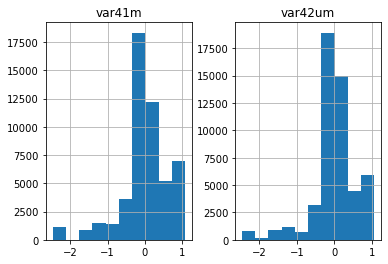

In [165]:
df3[df3["var41m"] != df3["var42um"]][["var41m","var42um"]].hist()

<AxesSubplot:>

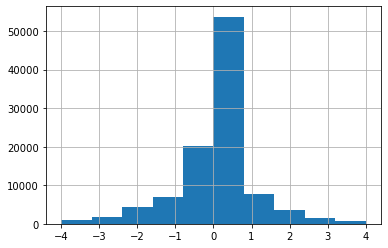

In [163]:
df_exchange_pairs["value4"].hist()

<AxesSubplot:>

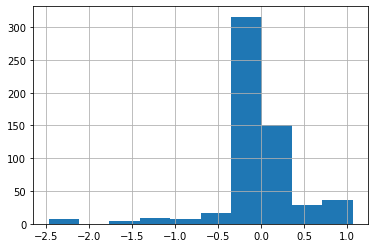

In [168]:
df_matched["var4"].hist()

<AxesSubplot:>

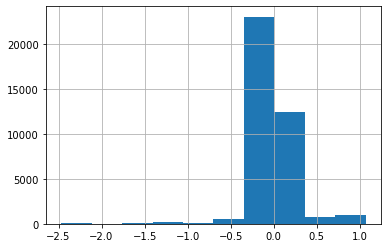

In [169]:
df_unmatched["var4"].hist()